In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import copy
import pandas as pd
import seaborn as sns
import torch.optim as optim

In [2]:
def loss_func(pred, y): return (pred-y)**2

In [3]:
def train(server_model, num_global_iters = 50, num_local_iters = 10, local_iter_thres = None,  lr = 0.1):
    # server_model = Model()
    client_models = [copy.deepcopy(server_model) for i in range(2)]

    memory = list()
    memory.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy() * server_model.scale.data.detach().cpu().numpy()))
    memory_w = list()
    memory_w.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()))
    memory_b = list()
    memory_b.append(copy.deepcopy(server_model.scale.data.detach().cpu().numpy()))
    memory_loss = list()
    memory_c1 = list()
    memory_c1.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[0]**2 - server_model.scale.data.detach().cpu().numpy()**2))
    memory_c2 = list()
    memory_c2.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[1]**2 - server_model.scale.data.detach().cpu().numpy()**2))

    import pandas as pd
    if local_iter_thres == None: alg = "FedAvg"
    else: alg = "FedBug"
    def df_append(df, data): df.loc[len(df)] = data
    df = pd.DataFrame(columns=["w1", "w2", "v", "alg"])
    df_append(df,  [copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[0]), 
                    copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[1]),
                    copy.deepcopy(server_model.scale.data.detach().cpu().numpy()), alg])
    for epoch in range(num_global_iters):  
        
        client_models = [copy.deepcopy(server_model) for i in range(2)]
        optimizers = [optim.SGD(client_models[idx].parameters(), lr=lr) for idx in range(2)]
        
        for client_idx in range(2):
            model, optimizer = client_models[client_idx], optimizers[client_idx]
            X, Y = Data[client_idx]
            for local_iter in range(num_local_iters):
                
                if local_iter_thres == None: model.scale.requires_grad = True
                elif local_iter < local_iter_thres: model.scale.requires_grad = False
                else: model.scale.requires_grad = True
                                
                pred = model(X)
                loss = loss_func(pred, Y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if local_iter_thres == None: pass

                memory_c1.append(copy.deepcopy(model.weight.data.detach().cpu().numpy()[0]**2 - model.scale.data.detach().cpu().numpy()**2))
                memory_c2.append(copy.deepcopy(model.weight.data.detach().cpu().numpy()[1]**2 - model.scale.data.detach().cpu().numpy()**2))
                
        with torch.no_grad():
            server_model.weight.data.copy_(copy.deepcopy((client_models[0].weight.data + client_models[1].weight.data)/2))
            server_model.scale.data.copy_(copy.deepcopy((client_models[0].scale.data + client_models[1].scale.data)/2))
            memory.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy() * server_model.scale.data.detach().cpu().numpy()))
            memory_w.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()))
            memory_b.append(copy.deepcopy(server_model.scale.data.detach().cpu().numpy()))
            memory_c1.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[0]**2 - server_model.scale.data.detach().cpu().numpy()**2))
            memory_c2.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[1]**2 - server_model.scale.data.detach().cpu().numpy()**2))
            df_append(df,  [copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[0]), 
                            copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[1]),
                            copy.deepcopy(server_model.scale.data.detach().cpu().numpy()[0]), 
                            alg])
            loss = 0
            for client_idx in range(2):
                X, Y = Data[client_idx]
                pred = server_model(X)
                loss += loss_func(pred, Y).item() / 2
            memory_loss.append(loss)
    memory = np.array(memory)
    memory_loss = np.array(memory_loss)
    memory_w = np.array(memory_w)
    memory_b = np.array(memory_b)
    return memory, memory_loss, memory_w, memory_b, memory_c1, memory_c2, df

In [60]:
class Model(torch.nn.Module):
    def __init__(self, w = [0.6, 3], v = 0.5):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(w),  requires_grad=True)
        self.scale  = torch.nn.Parameter(torch.Tensor([v]),    requires_grad=True)
    def forward(self, x): return x @ self.weight * self.scale
Data = [[torch.Tensor([1, 0]), torch.Tensor([1])], 
        [torch.Tensor([0, 1]), torch.Tensor([1])]]

lr = 0.1
num_global_iters = 80
num_local_iters = 40
local_iter_thres = 1
# memory, memory_loss, memory_w, memory_b, memory_c1, memory_c2, df = train(index = 0, num_global_iters = num_global_iters, num_local_iters = num_local_iters, local_iter_thres = None,  lr = lr)
# memory2, memory_loss2, memory_w2, memory_b2, memory_c1_2, memory_c2_2, df2 = train(index = 0, num_global_iters = num_global_iters, num_local_iters = num_local_iters, local_iter_thres = local_iter_thres,  lr = lr)

In [64]:
def df_append(df, data): df.loc[len(df)] = data
df_FedAvg = pd.DataFrame(columns=["seed", "w1", "w2", "b", "CDCR_EM_Avg", "CDCR_EM_Bug", "CDCR_TH", "alg"])


for i in range(20):
    # if (i+1) % 5 == 0:
    print(i)
        # break

    alg = "FedAvg"
    np.random.seed(i)
    w = np.random.rand(2)*3
    v = np.random.rand(1)*3
    model = Model(w = w, v = v)
    _, _, memory_w, memory_b, _, _, _ = train(model, num_global_iters = num_global_iters+20, num_local_iters = num_local_iters, local_iter_thres = None, lr = lr)
    WeightDiff = np.abs(memory_w[10:20, 0] - memory_w[10:20, 1])
    CDCR_EM_Avg = (WeightDiff[1:] / WeightDiff[:-1]).mean()
    
    # for num_local_step_frozen in [2, 4, 8, 16]:
    for num_local_step_frozen in [2, 4, 8, 16]:
        alg = "FedBUG_" + str(num_local_step_frozen)

        np.random.seed(i)
        w = np.random.rand(2)*3
        v = np.random.rand(1)*3
        model = Model(w = w, v = v)
        _, _, memory_w, memory_b, _, _, _ = train(model, num_global_iters = num_global_iters+20, num_local_iters = num_local_iters, local_iter_thres = num_local_step_frozen, lr = lr)
        WeightDiff = np.abs(memory_w[5:15, 0] - memory_w[5:15, 1])

        # print(memory_w[10:20, 0])
        # print(np.log(np.abs(memory_w[10:20, 0] - memory_w[10:20, 1])))
        CDCR_EM_Bug = (WeightDiff[1:] / WeightDiff[:-1]).mean()

        slope = -memory_b[-10:].mean()**2
        model_log_decay = 1 - np.sin(np.arctan(slope))**2 / 2
                            
        df_append(df_FedAvg, [i, w[0], w[1], v[0], CDCR_EM_Avg, CDCR_EM_Bug, model_log_decay, alg])

0
1
2
3
4
5
6
7
8
9
10
11


KeyboardInterrupt: 

In [ ]:
## The case that initilized from [0,3]

Text(0, 0.5, 'Empirical contraction ratio of FedBug')

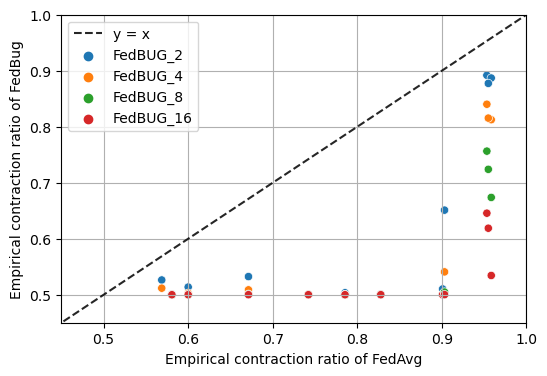

In [65]:
# df_BUG.to_csv("./SaveFig/0424_DecayData/WeightDiffDecayFedBUG_0424_2030.csv")
# df = pd.read_csv("./SaveFig/0424_DecayData/WeightDiffDecayFedBUG_0424_2030.csv")
df = copy.deepcopy(df_FedAvg)
fig, ax = plt.subplots(1,1,figsize=(6,4))
maxv = 1
ax.plot([0.1, maxv], [0.1, maxv], "black", linestyle='--', alpha=0.85, label = "y = x")
df["Algorithm"] = df["alg"]
# replace_icon =   {
#                 # "FedAvg": "FedAvg", 
#                   "FedBUG_1":  "FedBUG: 1%", 
#                   "FedBUG_3":  "FedBUG: 3%", 
#                   "FedBUG_10": "FedBUG: 10%", 
#                   "FedBUG_30": "FedBUG: 30%", 
#                  }
# sk = list(replace_icon.keys())
# df = df.set_index('Algorithm').loc[sk].reset_index()
# df = df.replace({"Algorithm": replace_icon})
sns.scatterplot(data=df, x="CDCR_EM_Avg", y="CDCR_EM_Bug", hue = "Algorithm", ax=ax)
# ax.plot([-0.1, -maxv], [-0.1, -maxv], "tab:blue", linestyle='--', alpha=0.75, label = "Fitted Curve ($R^2=0.99995$)")

ax.set_ylim([0.45, maxv]), ax.set_xlim([0.45, maxv]), ax.legend(), ax.grid()
ax.set_xlabel("Empirical contraction ratio of FedAvg")
ax.set_ylabel("Empirical contraction ratio of FedBug")

In [ ]:
## The case that initilized from [0,2]

Text(0, 0.5, 'Empirical contraction ratio of FedBug')

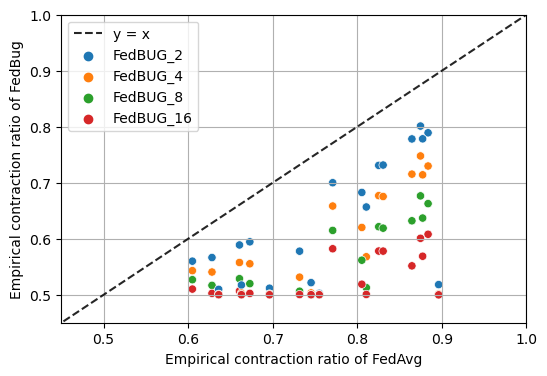

In [63]:
# df_BUG.to_csv("./SaveFig/0424_DecayData/WeightDiffDecayFedBUG_0424_2030.csv")
# df = pd.read_csv("./SaveFig/0424_DecayData/WeightDiffDecayFedBUG_0424_2030.csv")
df = copy.deepcopy(df_FedAvg)
fig, ax = plt.subplots(1,1,figsize=(6,4))
maxv = 1
ax.plot([0.1, maxv], [0.1, maxv], "black", linestyle='--', alpha=0.85, label = "y = x")
df["Algorithm"] = df["alg"]
# replace_icon =   {
#                 # "FedAvg": "FedAvg", 
#                   "FedBUG_1":  "FedBUG: 1%", 
#                   "FedBUG_3":  "FedBUG: 3%", 
#                   "FedBUG_10": "FedBUG: 10%", 
#                   "FedBUG_30": "FedBUG: 30%", 
#                  }
# sk = list(replace_icon.keys())
# df = df.set_index('Algorithm').loc[sk].reset_index()
# df = df.replace({"Algorithm": replace_icon})
sns.scatterplot(data=df, x="CDCR_EM_Avg", y="CDCR_EM_Bug", hue = "Algorithm", ax=ax)
# ax.plot([-0.1, -maxv], [-0.1, -maxv], "tab:blue", linestyle='--', alpha=0.75, label = "Fitted Curve ($R^2=0.99995$)")

ax.set_ylim([0.45, maxv]), ax.set_xlim([0.45, maxv]), ax.legend(), ax.grid()
ax.set_xlabel("Empirical contraction ratio of FedAvg")
ax.set_ylabel("Empirical contraction ratio of FedBug")

In [25]:
df

,Algorithm,seed,w1,w2,b,CDCR_EM_Avg,CDCR_EM_Bug,CDCR_TH,alg
0,FedBUG: 2%,0,1.097627,1.430379,1.205527,0.810652,0.509041,0.665601,FedBUG_1
1,FedBUG: 2%,1,0.834044,1.440649,0.000229,0.864570,0.604224,0.869274,FedBUG_1
2,FedBUG: 2%,2,0.871990,0.051852,1.099325,0.628093,0.513153,0.692353,FedBUG_1
3,FedBUG: 2%,3,1.101596,1.416296,0.581809,0.874733,0.651846,0.908912,FedBUG_1
4,FedBUG: 4%,0,1.097627,1.430379,1.205527,0.810652,0.509041,0.665601,FedBUG_2
5,FedBUG: 4%,1,0.834044,1.440649,0.000229,0.864570,0.604224,0.869274,FedBUG_2
6,FedBUG: 4%,2,0.871990,0.051852,1.099325,0.628093,0.513153,0.692353,FedBUG_2
7,FedBUG: 4%,3,1.101596,1.416296,0.581809,0.874733,0.651846,0.908912,FedBUG_2
8,FedBUG: 20%,0,1.097627,1.430379,1.205527,0.810652,0.509041,0.665601,FedBUG_10
9,FedBUG: 20%,1,0.834044,1.440649,0.000229,0.864570,0.604224,0.869274,FedBUG_10


0.9999450610514747

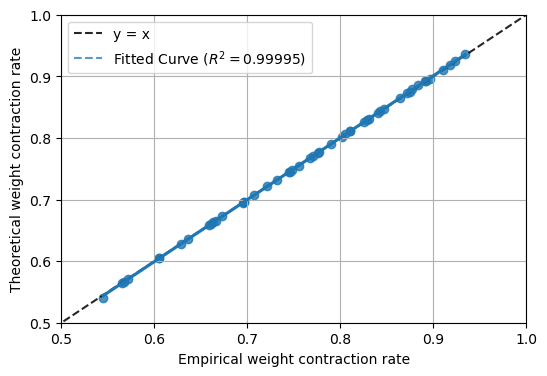

In [59]:
# df_FedAvg.to_csv("./SaveFig/0424_DecayData/WeightDiffDecay_0424_2000.csv")
df = pd.read_csv("./SaveFig/0424_DecayData/WeightDiffDecay_0424_2000.csv")
fig, ax = plt.subplots(1,1,figsize=(6,4))
maxv = 1
ax.plot([0.1, maxv], [0.1, maxv], "black", linestyle='--', alpha=0.85, label = "y = x")
df["Algorithm"] = df["alg"]
sns.regplot(data=df, x="loss_log_decay", y="estimated_log_decay", ax=ax)
ax.plot([-0.1, -maxv], [-0.1, -maxv], "tab:blue", linestyle='--', alpha=0.75, label = "Fitted Curve ($R^2=0.99995$)")

ax.set_ylim([0.5, maxv]), ax.set_xlim([0.5, maxv]), ax.legend(), ax.grid()
ax.set_xlabel("Empirical weight difference contraction rate")
ax.set_ylabel("Theoretical weight difference contraction rate")

from scipy import stats
def r2(x, y): return stats.pearsonr(x, y)[0] ** 2
r2(df["loss_log_decay"], df["estimated_log_decay"])

In [81]:
def df_append(df, data): df.loc[len(df)] = data
df_BUG = pd.DataFrame(columns=["w1", "w2", "b", "loss_log_decay", "estimated_log_decay", "alg"])

for num_local_step_frozen in [1, 2, 5, 10, 25]:
    alg = "FedBUG_" + str(num_local_step_frozen)
    for i in range(50):
        if (i+1) % 10 == 0: print(i+1)
        np.random.seed(i)
        w = np.random.rand(2)*2
        v = np.random.rand(1)*2
        model = Model(w = w, v = v)
        memory, memory_loss, memory_w, memory_b, _, _, _ = train(model, num_global_iters = num_global_iters, num_local_iters = num_local_iters, local_iter_thres = num_local_step_frozen,  lr = lr)
        
        WeightDiff = np.abs(memory_w[10:20, 0] - memory_w[10:20, 1])
        WeightDiffDecay = (WeightDiff[1:] / WeightDiff[:-1]).mean()
        
        slope = -memory_b[-10:].mean()**2
        model_log_decay = 1 - np.sin(np.arctan(slope))**2 / 2
                            
        df_append(df_BUG,  [w[0], w[1], v[0], WeightDiffDecay, model_log_decay, alg])

10
20
30
40
50
10
20
30
40
50
10
20
30
40
50
10
20
30
40
50
10
20
30
40
50


0.5322686977035392

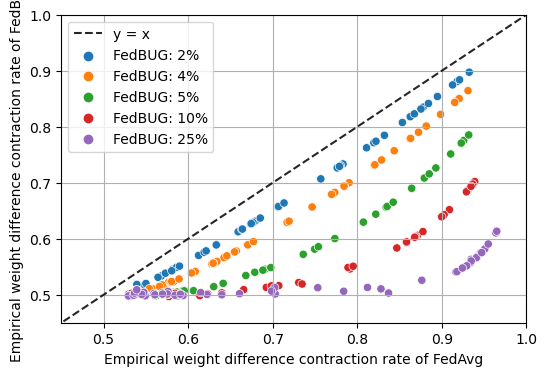

In [85]:
df_BUG.to_csv("./SaveFig/0424_DecayData/WeightDiffDecayFedBUG_0424_2030.csv")
# df = pd.read_csv("./SaveFig/0424_DecayData/WeightDiffDecayFedBUG_0424_2030.csv")
df = copy.deepcopy(df_BUG)
fig, ax = plt.subplots(1,1,figsize=(6,4))
maxv = 1
ax.plot([0.1, maxv], [0.1, maxv], "black", linestyle='--', alpha=0.85, label = "y = x")
df["Algorithm"] = df["alg"]
replace_icon =   {
                # "FedAvg": "FedAvg", 
                  "FedBUG_1":  "FedBUG: 2%", 
                  "FedBUG_2":  "FedBUG: 4%", 
                  "FedBUG_5":  "FedBUG: 5%", 
                  "FedBUG_10": "FedBUG: 10%", 
                  "FedBUG_25": "FedBUG: 25%", 
                 }
sk = list(replace_icon.keys())
df = df.set_index('Algorithm').loc[sk].reset_index()
df = df.replace({"Algorithm": replace_icon})
sns.scatterplot(data=df, x="estimated_log_decay", y="loss_log_decay", hue = "Algorithm", ax=ax)
# ax.plot([-0.1, -maxv], [-0.1, -maxv], "tab:blue", linestyle='--', alpha=0.75, label = "Fitted Curve ($R^2=0.99995$)")

ax.set_ylim([0.45, maxv]), ax.set_xlim([0.45, maxv]), ax.legend(), ax.grid()
ax.set_xlabel("Empirical contraction rate of FedAvg")
ax.set_ylabel("Empirical contraction rate of FedBUG")

0.5322686977035392

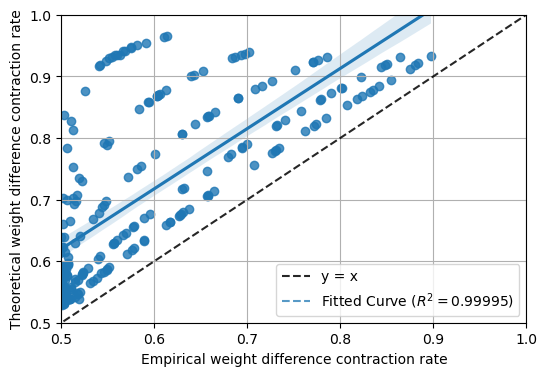

In [83]:
# df_FedAvg.to_csv("./SaveFig/0424_DecayData/WeightDiffDecay_0424_2000.csv")
# df = pd.read_csv("./SaveFig/0424_DecayData/WeightDiffDecay_0424_2000.csv")
df = copy.deepcopy(df_BUG)
fig, ax = plt.subplots(1,1,figsize=(6,4))
maxv = 1
ax.plot([0.1, maxv], [0.1, maxv], "black", linestyle='--', alpha=0.85, label = "y = x")
df["Algorithm"] = df["alg"]
sns.regplot(data=df, x="loss_log_decay", y="estimated_log_decay", ax=ax)
ax.plot([-0.1, -maxv], [-0.1, -maxv], "tab:blue", linestyle='--', alpha=0.75, label = "Fitted Curve ($R^2=0.99995$)")

ax.set_ylim([0.5, maxv]), ax.set_xlim([0.5, maxv]), ax.legend(), ax.grid()
ax.set_xlabel("Empirical weight difference contraction rate")
ax.set_ylabel("Theoretical weight difference contraction rate")

from scipy import stats
def r2(x, y): return stats.pearsonr(x, y)[0] ** 2
r2(df["loss_log_decay"], df["estimated_log_decay"])

In [ ]:
df

,Unnamed: 0,Algorithm,w1,w2,b,loss_log_decay,estimated_log_decay,alg
0,0,FedAvg,1.097627,1.430379,1.205527,0.419829,0.378646,FedAvg
1,1,FedAvg,0.834044,1.440649,0.000229,0.291233,0.270276,FedAvg
2,2,FedAvg,0.871990,0.051852,1.099325,0.930434,0.743857,FedAvg
3,3,FedAvg,1.101596,1.416296,0.581809,0.267753,0.250301,FedAvg
4,4,FedAvg,1.934060,1.094464,1.945369,0.562001,0.489929,FedAvg
...,...,...,...,...,...,...,...,...
245,245,FedBUG: 25%,1.978023,1.099089,0.562895,0.720453,0.126866,FedBUG_10
246,246,FedBUG: 25%,1.567665,1.269667,0.498086,0.731461,0.131017,FedBUG_10
247,247,FedBUG: 25%,0.226977,1.948966,1.457469,1.369777,0.818082,FedBUG_10
248,248,FedBUG: 25%,0.034981,1.783147,0.569722,1.012538,0.264236,FedBUG_10


Text(0, 0.5, 'Theoretical distance contrastion (log-scale)')

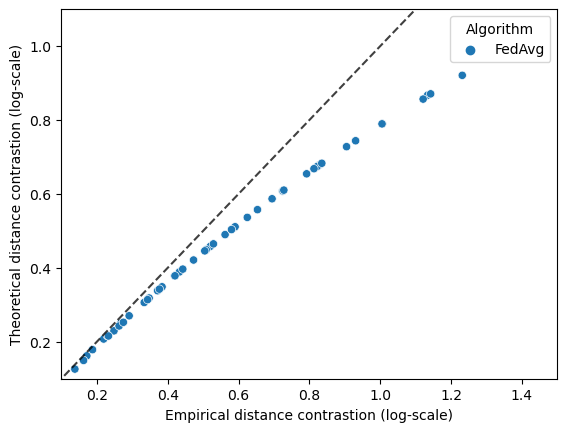

In [10]:
import seaborn as sns 
fig, axes = plt.subplots(1,1)
ax = axes
# df_temp = copy.deepcopy(pd.concat([df, df_BUG]))
df_temp = pd.read_csv("LogDecayDF_0424.csv")

# df_temp["Algorithm"] = df_temp["alg"]
# replace_icon =   {"FedAvg": "FedAvg", 
#                   "FedBUG_1":  "FedBUG: 2.5%", 
#                   "FedBUG_2":  "FedBUG: 5%", 
#                   "FedBUG_4":  "FedBUG: 10%", 
#                   "FedBUG_10": "FedBUG: 25%", 
#                  }
# sk = list(replace_icon.keys())
# df_temp = df_temp.set_index('Algorithm').loc[sk].reset_index()
# df_temp = df_temp.replace({"Algorithm": replace_icon})

df_temp = df_temp[df_temp["Algorithm"]=="FedAvg"]
sns.scatterplot(data=df_temp, x="loss_log_decay", y="estimated_log_decay", hue="Algorithm", ax=ax)
maxv = 1.5
ax.plot([0, maxv], [0, maxv], "black", linestyle='--', alpha=0.75)
ax.set_ylim([0.1,1.1])
ax.set_xlim([0.1,maxv])

ax.set_xlabel("Empirical distance contrastion (log-scale)")
ax.set_ylabel("Theoretical distance contrastion (log-scale)")

# df_temp.to_csv("LogDecayDF_0424.csv")